In [1]:
import torch
import math
from typing import Dict, List, Tuple, Any
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.checkpoint import checkpoint
from torch.utils.tensorboard.writer import SummaryWriter
from config import NODE_FEATURE_DIMENSION, EDGE_FEATURE_DIMENSION, MAX_NUM_PRIMITIVES, GRAPH_EMBEDDING_SIZE
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from dataset1 import SketchDataset
from tqdm import tqdm
from functools import partial
from IPython import display
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

### MODULES

In [2]:
class CosineNoiseScheduler(nn.Module):
  def __init__(self, max_timestep : int, device : torch.device):
    super().__init__()
    self.device = device
    self.max_timestep = max_timestep
    self.offset = .008 # Fixed offset to improve noise prediction at early timesteps
    # Cosine Beta Schedule Formula: https://arxiv.org/abs/2102.09672     1.00015543316 is 1/a(0), for offset = .008
    self.cumulative_precisions = torch.cos((torch.linspace(0, 1, self.max_timestep).to(self.device) + self.offset) * 0.5 * math.pi / (1 + self.offset)) ** 2 * 1.00015543316
    self.cumulative_variances = 1 - self.cumulative_precisions
    self.variances = torch.cat([torch.Tensor([0]).to(self.device), 1 - (self.cumulative_precisions[1:] / self.cumulative_precisions[:-1])]).clamp(.0001, .9999)
    self.precisions = 1 - self.variances
    self.sqrt_cumulative_precisions = torch.sqrt(self.cumulative_precisions)
    self.sqrt_cumulative_variances = torch.sqrt(self.cumulative_variances)
    self.sqrt_precisions = torch.sqrt(self.precisions)
    self.sqrt_variances = torch.sqrt(self.variances)
    self.sqrt_posterior_variances = torch.cat([torch.Tensor([0]).to(self.device), torch.sqrt(self.variances[1:] * self.cumulative_variances[:-1] / self.cumulative_variances[1:])])
  
  def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
    ''' Apply noise to graph '''
    noisy_nodes = torch.zeros(size = nodes.size(), device = nodes.device)
    noisy_edges = torch.zeros(size = edges.size(), device = edges.device)
    # nodes = batch_size x num_nodes x NODE_FEATURE_DIMENSION ; edges = batch_size x num_nodes x num_nodes x EDGE_FEATURE_DIMENSION
    bernoulli_is_constructible = nodes[:,:,0] # batch_size x num_nodes x 1
    categorical_primitive_types = nodes[:,:,1:6] # batch_size x num_nodes x 5
    gaussian_primitive_parameters = nodes[:,:,6:] # batch_size x num_nodes x 14
    # subnode just means if the constraint applies to the start, center, or end of a primitive
    categorical_subnode_a_types = edges[:,:,:,0:4] # batch_size x num_nodes x 4
    categorical_subnode_b_types = edges[:,:,:,4:8] # batch_size x num_nodes x 4
    categorical_constraint_types = edges[:,:,:,8:] # batch_size x num_nodes x 9
    # IsConstructible noise
    noisy_nodes[:,:,0] = self.apply_binary_noise(bernoulli_is_constructible, timestep)
    # Primitive Types noise
    noisy_nodes[:,:,1:6] = self.apply_discrete_noise(categorical_primitive_types, timestep) # noised_primitive_types
    # Primitive parameters noise
    gaussian_noise = torch.randn_like(gaussian_primitive_parameters) # standard gaussian noise
    noisy_nodes[:,:,6:] = self.apply_gaussian_noise(gaussian_primitive_parameters, timestep, gaussian_noise)
    # Subnode A noise
    noisy_edges[:,:,:,0:4] = self.apply_discrete_noise(categorical_subnode_a_types, timestep) # noised_subnode_a_types
    # Subnode B noise
    noisy_edges[:,:,:,4:8] = self.apply_discrete_noise(categorical_subnode_b_types, timestep) # noised_subnode_a_types
    # Constraint Types noise
    noisy_edges[:,:,:,8:] = self.apply_discrete_noise(categorical_constraint_types, timestep) # noised_constraint_types
    return noisy_nodes, noisy_edges, gaussian_noise
  
  def get_transition_noise(self, parameters : Tensor, timestep : int, gaussian_noise : Tensor = None):
    if gaussian_noise is None:
      gaussian_noise = torch.randn_like(parameters) # standard gaussian noise
    return self.sqrt_precisions[timestep] * parameters + self.sqrt_variances[timestep] * gaussian_noise
  
  def apply_gaussian_noise(self, parameters : Tensor, timestep : Tensor | int, gaussian_noise : Tensor = None):
    if gaussian_noise is None:
      gaussian_noise = torch.randn_like(parameters) # standard gaussian noise
    
    if type(timestep) is int: timestep = [timestep]
    # parameters shape is batch_size x num_nodes x num_params
    # gaussian_noise shape is batch_size x num_nodes x num_params
    batched_precisions = self.sqrt_cumulative_precisions[timestep,None,None] # (b,1,1) or (1,1,1)
    batched_variances = self.sqrt_cumulative_variances[timestep,None,None]   # (b,1,1) or (1,1,1)
    return batched_precisions * parameters + batched_variances * gaussian_noise
  
  def apply_gaussian_posterior_step(self, curr_params : Tensor, pred_params : Tensor, timestep : int):
    if timestep > 1:
      sqrt_prev_cumul_prec = self.sqrt_cumulative_precisions[timestep - 1]
      var = self.variances[timestep]
      sqrt_prec = self.sqrt_precisions[timestep]
      prev_cumul_var = self.cumulative_variances[timestep - 1]
      cumul_var = self.cumulative_variances[timestep]
      
      denoised_mean = (sqrt_prev_cumul_prec * var * pred_params + sqrt_prec * prev_cumul_var * curr_params) / cumul_var

      gaussian_noise = torch.randn_like(curr_params)
      return denoised_mean + gaussian_noise * self.sqrt_posterior_variances[timestep]
    else:
      return pred_params # denoised_mean
    
  def get_transition_matrix(self, dimension : int, timestep : int | Tensor):
    if type(timestep) is int: assert timestep > 0; timestep = [timestep]
    batched_precisions = self.sqrt_precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
    return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) / dimension # (batch_size, d, d) or (1, d, d)
  
  def get_cumulative_transition_matrix(self, dimension : int, timestep : int | Tensor):
    if type(timestep) is int: assert timestep > 0; timestep = [timestep]
    batched_precisions = self.sqrt_cumulative_precisions[timestep,None,None] # (batch_size, 1, 1) or (1, 1, 1)
    return batched_precisions * torch.eye(dimension, dtype = torch.float32, device = self.device) + (1 - batched_precisions) / dimension # (batch_size, d, d) or (1, d, d)
  
  def get_posterior_transition_matrix(self, xt : Tensor, timestep : Tensor | int) -> torch.Tensor:
    xt_size, xt = self.flatten_middle(xt) # (b, n, d) or (b, n * n, d), for convenience let m = n or n * n
    d = xt_size[-1]
    qt = xt @ self.get_transition_matrix(d, timestep).permute(0, 2, 1) # (b, m, d), since xt is onehot we are plucking out rows corresponding to p(x_t = class | x_(t-1))
    qt_bar = xt @ self.get_cumulative_transition_matrix(d, timestep).permute(0, 2, 1) # (b, m, d), since xt is onehot we are plucking out rows corresponding to p(x_t = class | x_0)
    q = qt.unsqueeze(2) / qt_bar.unsqueeze(3) # (b, m, d, d), perform an outer product so element at (b, m, i, j) = p(x_t = class | x_(t-1) = j) / p(x_t = class | x_0 = i)
    q = q * self.get_cumulative_transition_matrix(d, timestep - 1).unsqueeze(1) # (b, m, d, d), broadcast multiply so element at (b, m, i, j) = p(x_t = class | x_(t-1) = j) * p(x_(t-1) = j | x_0 = i) / p(x_t = class | x_0 = i)
    return q.view(size = xt_size + (d,)) # reshape into (b, n, d, d) or (b, n, n, d, d)
  
  def apply_discrete_noise(self, x_one_hot : Tensor, timestep : Tensor | int):
    size, x = self.flatten_middle(x_one_hot)
    q = self.get_cumulative_transition_matrix(size[-1], timestep) # (b, d, d) or (1, d, d)
    distribution = x @ q # (b, n, d) or (b, n * n, d)
    distribution = distribution.view(size) # (b, n, d) or (b, n, n, d)
    return self.sample_discrete_distribution(distribution).float()
  
  def apply_multinomial_posterior_step(self, classes_one_hot : Tensor, pred_class_probs : Tensor, timestep : int):
    # classes_one_hot = (b, n, d) or (b, n, n, d)
    # pred_class_probs = (b, n, d) or (b, n, n, d)
    if timestep > 1:
      q = self.get_posterior_transition_matrix(classes_one_hot, timestep) # (b, n, d, d) or (b, n, n, d, d)
      pred_class_probs = pred_class_probs.unsqueeze(-2) # (b, n, 1, d) or (b, n, n, 1, d), make probs into row vector
      posterior_distribution = pred_class_probs @ q # (b, n, 1, d) or (b, n, n, 1, d), batched vector-matrix multiply
      posterior_distribution = posterior_distribution.squeeze(-2) # (b, n, d) or (b, n, n, d)
      return self.sample_discrete_distribution(posterior_distribution).float()
    else:
      return pred_class_probs
    
  def apply_binary_noise(self, boolean_flag : Tensor, timestep : int | Tensor):
    boolean_flag = boolean_flag.unsqueeze(-1)
    one_hot = torch.cat([1 - boolean_flag, boolean_flag], dim = -1) # (b, n, 2)
    noised_one_hot = self.apply_discrete_noise(one_hot, timestep) # (b, n, 2)
    return noised_one_hot[...,1] # (b, n)
  
  def apply_bernoulli_posterior_step(self, boolean_flag : Tensor, pred_boolean_prob : Tensor, timestep : int):
    if timestep > 1:
      boolean_flag = boolean_flag.unsqueeze(-1) # b, n, 1
      pred_boolean_prob = pred_boolean_prob.unsqueeze(-1) # b, n, 1
      one_hot_xt = torch.cat([1 - boolean_flag, boolean_flag], dim = -1) # (b, n, 2)
      probs = torch.cat([1 - pred_boolean_prob, pred_boolean_prob], dim = -1) # (b, n, 2)
      noised_one_hot = self.apply_multinomial_posterior_step(one_hot_xt, probs, timestep) # (b, n, 2)
      return noised_one_hot[...,1] # (b, n)
    else:
      return pred_boolean_prob
    
  def sample_discrete_distribution(self, tensor : Tensor):
    size = tensor.size()
    num_classes = size[-1]
    return F.one_hot(tensor.reshape(-1, num_classes).multinomial(1), num_classes).reshape(size)
  
  def flatten_middle(self, x : Tensor):
    prev_size = x.size() # shape of x_one_hot is (b, n, d) or (b, n, n, d)
    return prev_size, x.view(prev_size[0], -1, prev_size[-1]) # (b, n, d) or (b, n * n, d)

In [3]:
class TimeEmbedder(nn.Module):
  def __init__(self, max_timestep : int, embedding_dimension : int, device : torch.device):
    super().__init__()
    self.device = device
    self.embed_dim = embedding_dimension
    self.max_steps = max_timestep + 1
    self.max_timestep = max_timestep
      
    timesteps = torch.arange(self.max_steps, device = self.device).unsqueeze(1) # num_timesteps x 1
    scales = torch.exp(torch.arange(0, self.embed_dim, 2, device = self.device) * (-math.log(10000.0) / self.embed_dim)).unsqueeze(0) # 1 x (embedding_dimension // 2)
    self.time_embs = torch.zeros(self.max_steps, self.embed_dim, device = self.device) # num_timesteps x embedding_dimension
    self.time_embs[:, 0::2] = torch.sin(timesteps * scales) # fill even columns with sin(timestep * 1000^-(2*i/embedding_dimension))
    self.time_embs[:, 1::2] = torch.cos(timesteps * scales) # fill odd columns with cos(timestep * 1000^-(2*i/embedding_dimension))
      
  def forward(self, timestep : Tensor):
    return self.time_embs[timestep] # batch_size x embedding_dimension

In [4]:
class MPSiLU(nn.Module):
    def __init__(self):
        super().__init__()

        self.silu = nn.SiLU()
    
    def forward(self, x):
        return self.silu(x) / 0.596

In [5]:
class TransformerLayer(nn.Module):
    def __init__(self, num_heads : int, node_dim : int, edge_dim : int, device : torch.device):
        super().__init__()
        self.num_heads = num_heads
        self.node_dim = node_dim
        self.edge_dim = edge_dim

        self.lin_node_add_embs = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
        self.lin_node_mul_embs = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)

        self.lin_edge_add_embs = nn.Linear(in_features = self.node_dim, out_features = self.edge_dim, device = device)
        self.lin_edge_mul_embs = nn.Linear(in_features = self.node_dim, out_features = self.edge_dim, device = device)

        self.attention_heads = MultiHeadAttention(node_dim = self.node_dim, edge_dim = self.edge_dim, num_heads = self.num_heads, device = device)

        self.layer_norm_nodes = nn.Sequential(nn.LeakyReLU(0.01),
                                              nn.LayerNorm(normalized_shape = self.node_dim, device = device, elementwise_affine = False, bias = False), 
                                              nn.LeakyReLU(0.01),
                                             )

        self.layer_norm_edges = nn.Sequential(nn.LeakyReLU(0.01), 
                                              nn.LayerNorm(normalized_shape = self.edge_dim, device = device, elementwise_affine = False, bias = False), 
                                              nn.LeakyReLU(0.01),
                                             )

        self.mlp_nodes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                       nn.LeakyReLU(0.01),
                                    #    nn.Dropout(p = 0.1),
                                       nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                      )
        
        self.mlp_edges = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.edge_dim, device = device),
                                       nn.LeakyReLU(0.01),
                                    #    nn.Dropout(p = 0.1),
                                       nn.Linear(in_features = self.edge_dim, out_features = self.edge_dim, device = device),
                                      )
        
        self.layer_norm_nodes2 = nn.Sequential(nn.LeakyReLU(0.01),
                                               nn.LayerNorm(normalized_shape = self.node_dim, device = device, elementwise_affine = False, bias = False), 
                                               nn.LeakyReLU(0.01),
                                              )

        self.layer_norm_edges2 = nn.Sequential(nn.LeakyReLU(0.01),
                                               nn.LayerNorm(normalized_shape = self.edge_dim, device = device, elementwise_affine = False, bias = False), 
                                               nn.LeakyReLU(0.01),
                                              )
        
        self.sftmx_norm_time = nn.Sequential(# nn.LeakyReLU(0.01),
                                               nn.Softmax(dim = 1),
                                              )
    
    def forward(self, nodes : Tensor, edges : Tensor, time_emb : Tensor) -> Tuple[Tensor, Tensor]:
      # Inject timestep information
      time_node_add = self.lin_node_add_embs(time_emb).unsqueeze(1)
      time_node_mul = self.lin_node_mul_embs(time_emb).unsqueeze(1)
      nodes = nodes * time_node_mul + nodes + time_node_add

      time_edge_add = self.lin_edge_add_embs(time_emb).unsqueeze(1).unsqueeze(1)
      time_edge_mul = self.lin_edge_mul_embs(time_emb).unsqueeze(1).unsqueeze(1)
      edges = edges * time_edge_mul + edges + time_edge_add
      # edges = edges * time_mul.unsqueeze(1).unsqueeze(1) + edges + time_add.unsqueeze(1).unsqueeze(1)

      # Perform multi head attention
      # attn_nodes, attn_edges = checkpoint(self.attention_heads, nodes, edges, use_reentrant = False) # batch_size x num_nodes x node_dim ; batch_size x num_nodes x num_nodes x edge_dim
      attn_nodes, attn_edges, attn_embs = self.attention_heads(nodes, edges, time_emb)

      # Layer normalization with a skip connection
      attn_nodes = self.layer_norm_nodes(attn_nodes + nodes) # batch_size x num_nodes x node_dim
      attn_edges = self.layer_norm_edges(attn_edges + edges) # batch_size x num_nodes x num_nodes x edge_dim

      del nodes
      del edges

      # MLP out
      new_nodes = self.mlp_nodes(attn_nodes) # batch_size x num_nodes x node_dim
      new_edges = self.mlp_edges(attn_edges) # batch_size x num_nodes x num_nodes x edge_dim

      # Second layer normalization with a skip connection
      new_nodes = self.layer_norm_nodes2(new_nodes + attn_nodes) # batch_size x num_nodes x node_dim
      new_edges = self.layer_norm_edges2(new_edges + attn_edges) # batch_size x num_nodes x num_nodes x edge_dim
      del attn_nodes
      del attn_edges

      return new_nodes, new_edges, attn_embs # F.normalize(attn_embs, p = 2.0, dim = 1, eps = 1e-4)
    
# Outer Product Attention Head
class MultiHeadAttention(nn.Module):
    def __init__(self, node_dim : int, edge_dim : int, num_heads : int, device : torch.device):
        super().__init__()
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.num_heads = num_heads
        self.attn_dim = node_dim // num_heads

        self.lin_query = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                      )
        self.lin_key = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                      )
        self.lin_value = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device),
                                      )

        self.lin_mul = nn.Linear(in_features = self.edge_dim, out_features = self.node_dim, device = device)
        self.lin_add = nn.Linear(in_features = self.edge_dim, out_features = self.node_dim, device = device)
        #self.edge_film = FiLM(self.edge_dim, self.node_dim, device = device)

        # self.lin_tim_weight = nn.Linear(in_features = self.node_dim, out_features = 1, device = device)
        # self.lin_tim_mul = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
        # self.lin_tim_add = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)

        self.lin_nodes_out = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
        self.lin_edges_out = nn.Sequential(
                                           nn.Linear(in_features = self.node_dim, out_features = self.edge_dim, device = device),
                                          )

    def forward(self, nodes : Tensor, edges : Tensor, time_emb : Tensor):
        batch_size, num_nodes, _ = nodes.size()
        
        # Outer Product Attention -------
        queries = self.lin_query(nodes).view(batch_size, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_heads x attn_dim
        keys = self.lin_key(nodes).view(batch_size, num_nodes, self.num_heads, -1)      # batch_size x num_nodes x num_heads x attn_dim
        # queries = queries.unsqueeze(2)                            # batch_size x num_nodes x 1 x num_heads x attn_dim 
        # keys = keys.unsqueeze(1)                                  # batch_size x 1 x num_nodes x num_heads x attn_dim

        # Normalize magnitudes
        # queries = torch.nn.functional.normalize(queries, p=2.0, dim=3, eps=1e-4)
        # keys = torch.nn.functional.normalize(keys, p=2.0, dim=3, eps=1e-4)

        attention = queries.unsqueeze(2) * keys.unsqueeze(1) / math.sqrt(self.node_dim) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        del queries
        del keys

        # Condition attention based on edge features
        edges_mul = self.lin_mul(edges).view(batch_size, num_nodes, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        edges_add = self.lin_add(edges).view(batch_size, num_nodes, num_nodes, self.num_heads, -1) # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        del edges
        new_edges = attention * edges_mul + attention + edges_add # batch_size x num_nodes x num_nodes x num_heads x attn_dim
        del edges_add
        del edges_mul
        
        # Normalize attention
                                                                           # batch_size x num_nodes x num_nodes x num_heads (Finish dot product)
        attention = torch.softmax(input = new_edges.sum(dim = 4), dim = 2) # batch_size x num_nodes x num_nodes x num_heads (softmax) 

        # Weight node representations and sum
        values = self.lin_value(nodes).view(batch_size, num_nodes, self.num_heads, -1)  # batch_size x num_nodes x num_heads x attn_dim
        del nodes
                                                                                                             # batch_size x num_nodes x num_heads x attn_dim
        weighted_values = (attention.unsqueeze(4) * values.unsqueeze(1)).sum(dim = 2).flatten(start_dim = 2) # batch_size x num_nodes x node_dim
        del values

        # Flatten attention heads
        new_edges = new_edges.flatten(start_dim = 3)
        
        # Combine attention heads
        new_nodes = self.lin_nodes_out(weighted_values)
        new_edges = self.lin_edges_out(new_edges)

        # Incorporate Global Graph info into time embs
        # time_emb = time_emb.unsqueeze(1) # b, 1, d
        # normalized_vals = F.layer_norm(new_nodes, normalized_shape = (self.node_dim,), eps = 1e-4)
        # time_v_mul = self.lin_tim_mul(normalized_vals) # b, n, d
        # time_v_add = self.lin_tim_add(normalized_vals) # b, n, d
        # time_weight = self.lin_tim_weight(normalized_vals) # b, n, 1

        # time_emb = time_emb * time_v_mul + time_emb + time_v_add # b, n, d
        # time_emb = (time_weight.permute(0, 2, 1) @ time_emb).squeeze(1) # b, d

        return new_nodes, new_edges, time_emb

In [6]:
class SoftAttentionLayer(nn.Module):
  def __init__(self, node_dim : int, edge_dim : int, num_heads : int, device : torch.device):
    super().__init__()
    self.device = device
    self.node_dim = node_dim
    self.edge_dim = edge_dim
    self.num_heads = num_heads
    self.attn_dim = node_dim // num_heads
    self.num_nodes = MAX_NUM_PRIMITIVES

    concat_dim = 2 * self.node_dim + self.edge_dim

    self.lin_add_embs = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
    self.lin_mul_embs = nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = device)
    
    self.mlp_haggr_weights = nn.Sequential(nn.Linear(in_features = concat_dim, out_features = concat_dim, device = self.device),
                                           nn.LeakyReLU(0.01),
                                           nn.Linear(in_features = concat_dim, out_features = 1, device = self.device),
                                           nn.Softmax(dim = 2)
                                          )
    
    self.mlp_haggr_values = nn.Sequential(nn.Linear(in_features = concat_dim, out_features = concat_dim, device = self.device),
                                           nn.LeakyReLU(0.01),
                                           nn.Linear(in_features = concat_dim, out_features = self.node_dim, device = self.device),
                                         )

    self.query_key_value_mlp = nn.Linear(in_features = self.node_dim, out_features = 3 * self.node_dim, device = self.device)

    self.layer_norm_embs = nn.Sequential(nn.LayerNorm(normalized_shape = self.node_dim, device = self.device), nn.LeakyReLU(0.01),)

    self.time_weight_mlp = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
                                         nn.LeakyReLU(0.01),
                                         nn.Linear(in_features = self.node_dim, out_features = 1, device = self.device),
                                         nn.Softmax(dim = 2)
                                        )
    self.time_value_mlp = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
                                         nn.LeakyReLU(0.01),
                                         nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
                                         nn.Softmax(dim = 2)
                                        )

    self.node_mlp = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
                                  nn.LeakyReLU(0.01),
                                  nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
                                 )
    self.edge_mlp = nn.Sequential(nn.Linear(in_features = 2 * self.node_dim, out_features = self.edge_dim, device = self.device),
                                  nn.LeakyReLU(0.01),
                                  nn.Linear(in_features = self.edge_dim, out_features = self.edge_dim , device = self.device),
                                 )
    
    self.layer_norm_out_nodes = nn.Sequential(nn.LayerNorm(normalized_shape = self.node_dim, device = self.device), nn.LeakyReLU(0.01),)
    
    self.layer_norm_out_edges = nn.Sequential(nn.LayerNorm(normalized_shape = self.edge_dim, device = self.device), nn.LeakyReLU(0.01),)
    
  def forward(self, nodes : Tensor, edges : Tensor, time_emb : Tensor) -> Tuple[Tensor, Tensor]:
    # Inject timestep information
    time_add = self.lin_add_embs(time_emb).unsqueeze(1)
    time_mul = self.lin_mul_embs(time_emb).unsqueeze(1)
    nodes = nodes * time_mul + nodes + time_add
    # edges = edges * time_mul.unsqueeze(1).unsqueeze(1) + edges + time_add.unsqueeze(1).unsqueeze(1)

    # Outer Product Concatenation
    hstack = nodes.unsqueeze(2).expand(-1, -1, self.num_nodes, -1) # (b, n, n, d)
    vstack = hstack.permute(0, 2, 1, 3) # (b, n, n, d)
    graph_features = torch.cat(tensors = (hstack, vstack, edges), dim = 3) # (b, n, n, 3 * d)

    # Soft Attentional Encoder
    haggr_weights = self.mlp_haggr_weights(graph_features).permute(0, 1, 3, 2) # (b, n, 1, n)
    haggr_values = self.mlp_haggr_values(graph_features) # (b, n, n, d)
    graph_embs = (haggr_weights @ haggr_values).squeeze(2) # (b, n, d)

    # Low Dimensional Attention
    b, n, d = graph_embs.size()
    query_key_value = self.query_key_value_mlp(graph_embs).view(b, n, self.num_heads, 3 * self.attn_dim).permute(0, 2, 1, 3) # (b, h, n, 3 * attn_dim)
    queries, keys, values = query_key_value.reshape(b * self.num_heads, n, 3 * self.attn_dim).chunk(3, dim = 2) # (b * h, n, attn_dim) is shape for the three tensors
    attn_embs = F.scaled_dot_product_attention(queries, keys, values).view(b, self.num_heads, n, self.attn_dim) # (b * h, n, attn_dim)
    attn_embs = attn_embs.permute(0, 2, 1, 3).reshape(b, n, self.node_dim) # (b, n, d)

    # Residual Connection and LayerNorm
    attn_embs = self.layer_norm_embs(attn_embs + graph_embs)
    
    # Incorporate global graph info into time emb
    time_emb = time_mul * attn_embs + time_add + attn_embs
    time_weights = self.time_weight_mlp(time_emb) # b, n, 1
    time_values = self.time_value_mlp(time_emb) # b, n, d
    time_emb = (time_weights.permute(0, 2, 1) @ time_values).squeeze(1) # b, d

    # Outer Product Decoder
    emb_hstack = attn_embs.unsqueeze(2).expand(-1, -1, self.num_nodes, -1) # (b, n, n, d)
    emb_vstack = emb_hstack.permute(0, 2, 1, 3) # (b, n, n, d)
    emb_edges = torch.cat(tensors = (emb_hstack, emb_vstack), dim = 3) # (b, n, n, 2 * d)

    new_edges = self.edge_mlp(emb_edges) # (b, n, n, d)
    new_nodes = self.node_mlp(attn_embs) # (b, n, d)

    # Residual Connection and LayerNorm
    new_edges = self.layer_norm_out_edges(new_edges + edges)
    new_nodes = self.layer_norm_out_nodes(new_nodes + nodes)

    return new_nodes, new_edges, time_emb

In [7]:
class Block(nn.Module):
    def __init__(self, node_dim : int, edge_dim : int, num_heads : int, device : torch.device):
        super().__init__()
        self.device = device
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.num_heads = num_heads

        self.emb_mlp1 = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
                                      nn.LeakyReLU(0.01),
                                      nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
                                     )
        
        self.tf_layer = TransformerLayer(num_heads = self.num_heads, node_dim = self.node_dim, edge_dim = self.edge_dim, device = self.device)
        # self.soft_attn_layer1 = SoftAttentionLayer(node_dim = self.node_dim, edge_dim = self.edge_dim, num_heads = self.num_heads, device = self.device)

        self.emb_mlp2 = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
                                      nn.LeakyReLU(0.01),
                                      nn.Linear(in_features = self.node_dim, out_features = self.node_dim, device = self.device),
                                     )
        
        self.tf_layer2 = TransformerLayer(num_heads = self.num_heads, node_dim = self.node_dim, edge_dim = self.edge_dim, device = self.device)
        # self.soft_attn_layer2 = SoftAttentionLayer(node_dim = self.node_dim, edge_dim = self.edge_dim, num_heads = self.num_heads, device = self.device)

    def forward(self, nodes, edges, time_emb):

        time_emb = self.emb_mlp1(time_emb)
        nodes, edges, time_emb = self.tf_layer(nodes, edges, time_emb)

        time_emb = self.emb_mlp2(time_emb)
        nodes, edges, time_emb = self.tf_layer2(nodes, edges, time_emb)

        return nodes, edges, time_emb

In [8]:
class TransformerEncoder(nn.Module):
  def __init__(self, node_dim : int, edge_dim : int, graph_emb_dim : int, num_tf_layers: int, num_heads : int, device : torch.device): # perm_emb_dim: int,
    super().__init__()
    self.node_dim = node_dim # Number of features per node
    self.edge_dim = edge_dim # Number of features per edge
    self.graph_emb_dim = graph_emb_dim # Size of graph embedding vector
    self.num_nodes = MAX_NUM_PRIMITIVES # Number of nodes in each graph
    self.num_edges = self.num_nodes * self.num_nodes # Number of edges in each graph
    
    self.hidden_dim = 256
    self.num_tf_layers = num_tf_layers
    self.num_heads = num_heads
    self.mlp_in_nodes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.hidden_dim, device = device),
                                      nn.LeakyReLU(.1),
                                    #   nn.Dropout(p = 0.1),
                                      nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                      nn.LeakyReLU(.1),
                                    #   nn.Dropout(p = 0.1)
                                     )
    self.mlp_in_edges = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.hidden_dim, device = device),
                                      nn.LeakyReLU(.1),
                                    #   nn.Dropout(p = 0.1),
                                      nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                      nn.LeakyReLU(.1),
                                    #   nn.Dropout(p = 0.1)
                                     )
    
    self.tf_layers = nn.ModuleList([TransformerLayer(num_heads = self.num_heads, 
                                                     node_dim = self.hidden_dim,
                                                     edge_dim = self.hidden_dim, 
                                                     device = device
                                                    ) 
                                    for _ in range(self.num_tf_layers)])
    
    self.time_emb_mlps = nn.ModuleList([nn.Sequential(nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                                      nn.LeakyReLU(0.1),
                                                      nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                                      nn.LeakyReLU(0.1)
                                                     )
                                        for _ in range(self.num_tf_layers)])
    
    self.mlp_haggr_weights = nn.Sequential(nn.Linear(in_features = 3 * self.hidden_dim, out_features = 3 * self.hidden_dim, device = device),
                                          nn.LeakyReLU(.1),
                                        #   nn.Dropout(p = 0.1),
                                          nn.Linear(in_features = 3 * self.hidden_dim, out_features = 1, device = device),
                                          nn.Softmax(dim = 2),
                                        #   nn.Dropout(p = 0.1)
                                         )
    self.mlp_haggr_values = nn.Sequential(nn.Linear(in_features = 3 * self.hidden_dim, out_features = 3 * self.hidden_dim, device = device),
                                          nn.LeakyReLU(.1),
                                        #   nn.Dropout(p = 0.1),
                                          nn.Linear(in_features = 3 * self.hidden_dim, out_features = self.hidden_dim, device = device)
                                         )
    
    self.mlp_out = nn.Sequential(nn.Linear(in_features = self.num_nodes * self.hidden_dim, out_features = self.graph_emb_dim, device = device),
                                  nn.LeakyReLU(.1),
                                #   nn.Dropout(p = 0.1),
                                  nn.Linear(in_features = self.graph_emb_dim, out_features = self.graph_emb_dim, device = device)
                                 )
    
  def forward(self, nodes : Tensor, edges : Tensor, time_embs : Tensor):
    nodes = self.mlp_in_nodes(nodes) # batch_size x num_nodes x mlp_node_hidden_dim
    edges = self.mlp_in_edges(edges) # batch_size x num_nodes x num_nodes x mlp_edge_hidden_dim

    for idx in range(self.num_tf_layers):
      time_embs = self.time_emb_mlps[idx](time_embs)

      layer = self.tf_layers[idx]
      nodes, edges = layer(nodes, edges, time_embs)
      # nodes, edges = layer(nodes, edges) # batch_size x num_nodes x tf_node_hidden_dim ; batch_size x num_nodes x num_nodes x tf_edge_hidden_dim
    
    # nodes = nodes.flatten(start_dim = 1) # batch_size x (num_nodes * node_dim)
    # edges = edges.flatten(start_dim = 1) # batch_size x (num_nodes * num_nodes * edge_dim)
    # graph_embs = torch.cat((nodes, edges), 1) # batch_size x (num_nodes * node_dim + num_nodes * num_nodes * edge_dim)
    
    # Soft attentional aggregation
    hstack = nodes.unsqueeze(3).expand(-1, -1, -1, self.num_nodes).permute(0, 1, 3, 2) # batch_size x num_nodes x num_nodes x hidden_dim
    vstack = hstack.permute(0, 2, 1, 3) # batch_size x num_nodes x num_nodes x hidden_dim
    graph_features = torch.cat(tensors = (hstack, vstack, edges), dim = 3) # batch_size x num_nodes x num_nodes x (3 * hidden_dim)

    del nodes
    del edges
    del hstack
    del vstack

    haggr_weights = self.mlp_haggr_weights(graph_features) # batch_size x num_nodes x num_nodes x 1
    graph_features = self.mlp_haggr_values(graph_features) # batch_size x num_nodes x num_nodes x hidden_dim
    graph_embs = (haggr_weights.permute(0, 1, 3, 2) @ graph_features).squeeze().flatten(start_dim = 1) # batch_size x (num_nodes * hidden_dim)

    del haggr_weights
    del graph_features

    out_embs = self.mlp_out(graph_embs)     # batch_size x graph_emb_dim

    del graph_embs
    return out_embs, time_embs
  
class TransformerDecoder(nn.Module):
  def __init__(self, node_dim : int, edge_dim : int, graph_emb_dim : int, num_tf_layers : int, num_heads : int, device : torch.device):
    super().__init__()
    self.node_dim = node_dim
    self.edge_dim = edge_dim
    self.graph_emb_dim = graph_emb_dim
    self.num_nodes = MAX_NUM_PRIMITIVES # Number of nodes in each graph
    self.num_edges = self.num_nodes * self.num_nodes # Number of edges in each graph
    self.temp_node_dim = 128
    self.hidden_dim = 256
    self.num_tf_layers = num_tf_layers
    self.num_heads = num_heads
    self.mlp_create_nodes = nn.Sequential(nn.Linear(in_features = self.graph_emb_dim, out_features = self.num_nodes * self.temp_node_dim, device = device),
                                          nn.LeakyReLU(.1),
                                        #   nn.Dropout(p = 0.1),
                                          nn.Linear(in_features = self.num_nodes * self.temp_node_dim, out_features = self.num_nodes * self.temp_node_dim, device = device),
                                          nn.LeakyReLU(.1),
                                        #   nn.Dropout(p = 0.1)
                                         )
    self.mlp_create_edges = nn.Sequential(nn.Linear(in_features = self.graph_emb_dim, out_features = self.num_edges * self.edge_dim, device = device),
                                          nn.LeakyReLU(.1),
                                        #   nn.Dropout(p = 0.1),
                                          nn.Linear(in_features = self.num_edges * self.edge_dim, out_features = self.num_edges * self.edge_dim, device = device),
                                          nn.LeakyReLU(.1),
                                        #   nn.Dropout(p = 0.1)
                                         )
    
    self.lin_node_transform = nn.Sequential(nn.Linear(in_features = self.temp_node_dim, out_features = self.hidden_dim, device = device),
                                            nn.LeakyReLU(.1),
                                            # nn.Dropout(p = 0.1),
                                            nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                            nn.LeakyReLU(.1),
                                            # nn.Dropout(p = 0.1)
                                           )
    self.lin_edge_transform = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.hidden_dim, device = device),
                                            nn.LeakyReLU(.1),
                                            # nn.Dropout(p = 0.1),
                                            nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                            nn.LeakyReLU(.1),
                                            # nn.Dropout(p = 0.1)
                                           )
    
    self.tf_layers = nn.ModuleList([TransformerLayer(num_heads = self.num_heads, 
                                                     node_dim = self.hidden_dim,
                                                     edge_dim = self.hidden_dim,
                                                     device = device
                                                    ) 
                                    for _ in range(self.num_tf_layers)])
    self.time_emb_mlps = nn.ModuleList([nn.Sequential(nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                                      nn.LeakyReLU(0.1),
                                                      nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                                      nn.LeakyReLU(0.1)
                                                     )
                                        for _ in range(self.num_tf_layers)])
    
    self.mlp_out_nodes = nn.Sequential(nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                       nn.LeakyReLU(.1),
                                       nn.Linear(in_features = self.hidden_dim, out_features = self.node_dim, device = device)
                                      )
    self.mlp_out_edges = nn.Sequential(nn.Linear(in_features = self.hidden_dim, out_features = self.hidden_dim, device = device),
                                       nn.LeakyReLU(.1),
                                    #    nn.Dropout(p = 0.1),
                                       nn.Linear(in_features = self.hidden_dim, out_features = self.edge_dim, device = device)
                                      )

  def forward(self, latents, time_embs):
    nodes = torch.reshape(input = self.mlp_create_nodes(latents), shape = (-1, self.num_nodes, self.temp_node_dim))            # batch_size x num_nodes x mlp_node_out_dim
    edges = torch.reshape(input = self.mlp_create_edges(latents), shape = (-1, self.num_nodes, self.num_nodes, self.edge_dim)) # batch_size x num_nodes x num_nodes x mlp_edge_out_dim
    nodes = self.lin_node_transform(nodes) # batch_size x num_nodes x hidden_dim
    edges = self.lin_edge_transform(edges) # batch_size x num_nodes x num_nodes x hidden_dim
    for idx in range(self.num_tf_layers):
      time_embs = self.time_emb_mlps[idx](time_embs)

      layer = self.tf_layers[idx]
      nodes, edges = layer(nodes, edges, time_embs)
      # nodes, edges = layer(nodes, edges) # batch_size x num_nodes x tf_node_hidden_dim ; # batch_size x num_nodes x num_nodes x tf_edge_hidden_dim
    
    nodes = self.mlp_out_nodes(nodes) # batch_size x num_nodes x node_dim
    edges = self.mlp_out_edges(edges) # batch_size x num_nodes x num_nodes x edge_dim
    # # sigmoid and softmax for nodes
    # nodes[:,:,0] = F.sigmoid(nodes[:,:,0])              # Sigmoid for isConstructible
    # nodes[:,:,1:6] = F.softmax(nodes[:,:,1:6], dim = 2) # Softmax for primitive classes (i.e. line, circle, arc, point, none)
    
    # # softmax for constraints; Conceptual map => n1 (out) -> n2 (in) i.e. out_node, edge, in_node
    # edges[:,:,:,0:4] = F.softmax(edges[:,:,:,0:4], dim = 3) # Softmax for out_node subnode type
    # edges[:,:,:,4:8] = F.softmax(edges[:,:,:,4:8], dim = 3) # Softmax for in_node subnode type
    # edges[:,:,:,8: ] = F.softmax(edges[:,:,:,8: ], dim = 3) # Softmax for edge (aka constraint) type (i.e horizontal, vertical, etc...)
    return nodes, edges

In [9]:
class GD3PM(nn.Module):
  def __init__(self, device : torch.device):
    super().__init__()
    self.device = device
    self.node_dim = NODE_FEATURE_DIMENSION
    self.edge_dim = EDGE_FEATURE_DIMENSION
    self.node_hidden_dim = 128
    self.edge_hidden_dim = 128
    self.num_tf_layers = 12
    self.num_checkpoints = 0
    self.num_heads = 16
    self.max_timestep = 1000
    self.max_steps = self.max_timestep + 1
    self.noise_scheduler = CosineNoiseScheduler(self.max_timestep, self.device)
    self.time_embedder = TimeEmbedder(self.max_timestep, self.node_hidden_dim, self.device)

    self.mlp_in_nodes = nn.Sequential(nn.Linear(in_features = self.node_dim, out_features = self.node_hidden_dim, device = device),
                                            nn.LeakyReLU(0.01),
                                            # nn.Dropout(p = 0.1),
                                            nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
                                            nn.LeakyReLU(0.01),
                                            # nn.Dropout(p = 0.1)
                                           )
    self.mlp_in_edges = nn.Sequential(nn.Linear(in_features = self.edge_dim, out_features = self.edge_hidden_dim, device = device),
                                            nn.LeakyReLU(0.01),
                                            # nn.Dropout(p = 0.1),
                                            nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
                                            nn.LeakyReLU(0.01),
                                            # nn.Dropout(p = 0.1)
                                           )
    
    self.block_layers = nn.ModuleList([Block(node_dim = self.node_hidden_dim, edge_dim = self.edge_hidden_dim, num_heads = self.num_heads, device = self.device)
                                      for _ in range(self.num_tf_layers)])
    
    self.mlp_out_nodes = nn.Sequential(nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_hidden_dim, device = device),
                                       nn.LeakyReLU(0.01),
                                    #    nn.Dropout(p = 0.1),
                                       nn.Linear(in_features = self.node_hidden_dim, out_features = self.node_dim, device = device)
                                      )
    self.mlp_out_edges = nn.Sequential(nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_hidden_dim, device = device),
                                       nn.LeakyReLU(0.01),
                                    #    nn.Dropout(p = 0.1),
                                       nn.Linear(in_features = self.edge_hidden_dim, out_features = self.edge_dim, device = device)
                                      )

  def forward(self, nodes : Tensor, edges : Tensor, timestep : Tensor):
    # embed timestep
    time_encs = self.time_embedder(timestep) # batch_size x hidden_dim
    nodes = self.mlp_in_nodes(nodes) # batch_size x num_nodes x hidden_dim
    edges = self.mlp_in_edges(edges) # batch_size x num_nodes x num_nodes x hidden_dim

    num_checkpoint = self.num_checkpoints
    for idx in range(self.num_tf_layers):
      #nodes, edges, time_embs = layer(nodes, edges, time_embs) if idx % 8 == 0 else checkpoint(layer, nodes, edges, time_embs, use_reentrant = False)
      # time_encs = self.time_emb_mlps[idx](time_encs)
      # time_encs_mul = self.time_emb_mul_mlps[idx](time_encs_mul)
      # nodes = nodes * time_encs_mul.unsqueeze(1) + nodes + time_encs_add.unsqueeze(1)
      # edges = edges * time_encs_mul.unsqueeze(1).unsqueeze(1) + edges + time_encs_add.unsqueeze(1).unsqueeze(1)
      # time_encs_add = F.leaky_relu(time_encs_add, .1)
      # time_encs_mul = F.leaky_relu(time_encs_mul, .1)
        
      layer = self.block_layers[idx]
      nodes, edges, time_encs = layer(nodes, edges, time_encs)
      
      num_checkpoint = num_checkpoint - 1
    
    nodes = self.mlp_out_nodes(nodes)
    edges = self.mlp_out_edges(edges)
    return nodes, edges
  
  @torch.no_grad()
  def sample(self, batch_size : int):
    # Sample Noise
    num_nodes = MAX_NUM_PRIMITIVES
    num_node_features = NODE_FEATURE_DIMENSION
    num_edge_features = EDGE_FEATURE_DIMENSION
    nodes = torch.zeros(batch_size, num_nodes, num_node_features)
    edges = torch.zeros(batch_size, num_nodes, num_nodes, num_edge_features)
    # binary noise (isConstructible)
    nodes[:,:,0] = torch.ones(size = (batch_size * num_nodes, 2)).multinomial(1)\
                        .reshape(batch_size, num_nodes).float()
    # categorical noise (primitive type)
    nodes[:,:,1:6] = F.one_hot(torch.ones(size = (batch_size * num_nodes, 5)).multinomial(1), 5)\
                      .reshape(batch_size, num_nodes, -1).float()
    # gaussian noise (primitive parameters)
    nodes[:,:,6:] = torch.randn(size = (batch_size, num_nodes, 14))
    # categorical noise (subnode a type)
    edges[:,:,:,0:4] = F.one_hot(torch.ones(size = (batch_size * num_nodes * num_nodes, 4)).multinomial(1), 4)\
                      .reshape(batch_size, num_nodes, num_nodes, -1).float()
    # categorical noise (subnode b type)
    edges[:,:,:,4:8] = F.one_hot(torch.ones(size = (batch_size * num_nodes * num_nodes, 4)).multinomial(1), 4)\
                      .reshape(batch_size, num_nodes, num_nodes, -1).float()
    # categorical noise (subnode a type)
    edges[:,:,:,8:] = F.one_hot(torch.ones(size = (batch_size * num_nodes * num_nodes, 9)).multinomial(1), 9)\
                     .reshape(batch_size, num_nodes, num_nodes, -1).float()
    
    nodes = nodes.to(self.device)
    edges = edges.to(self.device)
    return self.denoise(nodes, edges)

  @torch.no_grad()
  def denoise(self, nodes, edges):
    for t in reversed(range(1, self.max_steps)):
      # model expects a timestep for each batch
      batch_size = nodes.size(0)
      time = torch.Tensor([t]).expand(batch_size).int()
      pred_node_noise, pred_edge_noise = self.forward(nodes, edges, time)
      # Normalize output into probabilities
      pred_node_noise[:,:,0] = F.sigmoid(input = pred_node_noise[:,:,0])
      pred_node_noise[:,:,1:6] = F.softmax(input = pred_node_noise[:,:,1:6], dim = 2)
      pred_edge_noise[:,:,:,0:4] = F.softmax(input = pred_edge_noise[:,:,:,0:4], dim = 3)
      pred_edge_noise[:,:,:,4:8] = F.softmax(input = pred_edge_noise[:,:,:,4:8], dim = 3)
      pred_edge_noise[:,:,:,8:] = F.softmax(input = pred_edge_noise[:,:,:,8:], dim = 3)
      nodes, edges = self.reverse_step(nodes, edges, pred_node_noise, pred_edge_noise, t)
    return nodes, edges
  
  @torch.no_grad()
  def noise(self, nodes, edges):
    nodes, edges, _ = self.noise_scheduler(nodes, edges, self.max_timestep)
    return nodes, edges
  
  @torch.no_grad()
  def reverse_step(self, curr_nodes : Tensor, curr_edges : Tensor, pred_nodes : Tensor, pred_edges : Tensor, timestep : int):
    new_nodes = torch.zeros_like(curr_nodes)
    new_edges = torch.zeros_like(curr_edges)
    # IsConstructible denoising
    new_nodes[:,:,0] = self.noise_scheduler.apply_bernoulli_posterior_step(curr_nodes[:,:,0], pred_nodes[:,:,0], timestep)
    # Primitive Types denoising
    new_nodes[:,:,1:6] = self.noise_scheduler.apply_multinomial_posterior_step(curr_nodes[:,:,1:6], pred_nodes[:,:,1:6], timestep)
    # Primitive parameters denoising
    new_nodes[:,:,6:] = self.noise_scheduler.apply_gaussian_posterior_step(curr_nodes[:,:,6:], pred_nodes[:,:,6:], timestep)
    # Subnode A denoising
    new_edges[:,:,:,0:4] = self.noise_scheduler.apply_multinomial_posterior_step(curr_edges[:,:,:,0:4], pred_edges[:,:,:,0:4], timestep)
    # Subnode B denoising
    new_edges[:,:,:,4:8] = self.noise_scheduler.apply_multinomial_posterior_step(curr_edges[:,:,:,4:8], pred_edges[:,:,:,4:8], timestep)
    # Constraint Types denoising
    new_edges[:,:,:,8:] = self.noise_scheduler.apply_multinomial_posterior_step(curr_edges[:,:,:,8:], pred_edges[:,:,:,8:], timestep)
    return new_nodes, new_edges

### Loss

In [10]:
def diffusion_loss(pred_nodes : Tensor, pred_edges : Tensor, true_nodes : Tensor, true_edges : Tensor, params_mask : Tensor, true_noise : Tensor, loss_dict : dict) -> Tensor:
    '''Edge Loss'''
    # Only apply subnode loss to constraints that are not none -------
    subnode_a_labels = torch.argmax(true_edges[:,:,:,0:4], dim = 3)
    subnode_a_logits = pred_edges[:,:,:,0:4]#.permute(0, 3, 1, 2).contiguous()
    sub_a_cross_entropy = F.cross_entropy(
        input = subnode_a_logits.reshape(-1, 4), 
        target = subnode_a_labels.flatten(), 
        reduction = 'mean')

    subnode_b_labels = torch.argmax(true_edges[:,:,:,4:8], dim = 3)
    subnode_b_logits = pred_edges[:,:,:,4:8]#.permute(0, 3, 1, 2).contiguous()
    sub_b_cross_entropy = F.cross_entropy(
        input = subnode_b_logits.reshape(-1, 4), 
        target = subnode_b_labels.flatten(), 
        reduction = 'mean')
    
    constraint_type_labels = torch.argmax(true_edges[:,:,:,8:], dim = 3)
    constraint_type_logits = pred_edges[:,:,:,8:]#.permute(0, 3, 1, 2).contiguous()
    # There are far more none constraint types, so weigh them less
    constraint_cross_entropy = F.cross_entropy(
        input = constraint_type_logits.reshape(-1, 9), 
        target = constraint_type_labels.flatten(),
        # weight = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.05]).to(pred_edges.device),
        reduction = 'mean')

    edge_loss = sub_a_cross_entropy + sub_b_cross_entropy + constraint_cross_entropy

    '''Node Loss'''
    # weight = torch.tensor([1.0, 2.0, 2.0, 1.0, 0.1]).to(pred_nodes.device)  # Weight circles, arcs, and points higher since they are much rarer than line and none types
    primitive_type_labels = torch.argmax(true_nodes[:,:,1:6], dim = 2)    # batch_size x num_nodes (class index for each node)
    primitive_type_logits = pred_nodes[:,:,1:6]#.permute(0,2,1).contiguous() # batch_size x num_primitive_types x num_nodes
    
    node_cross = F.cross_entropy(
        input = primitive_type_logits.reshape(-1, 5), 
        target = primitive_type_labels.flatten(),
        # weight = weight, 
        reduction = 'mean')
    
    pred_isconstruct = pred_nodes[:,:,0]
    target_isconstruct = true_nodes[:,:,0]
    bce = F.binary_cross_entropy_with_logits(
        input = pred_isconstruct, 
        target = target_isconstruct,
        # pos_weight = weight,
        reduction = 'mean')

    # pred_noise = pred_nodes[:,:,6:]
    # mse = ((pred_noise - true_noise) ** 2 * params_mask).sum() / params_mask.sum()
    pred_params = pred_nodes[:,:,6:]
    target_params = true_nodes[:,:,6:]
    mae = (torch.abs(pred_params - target_params) * params_mask).sum() / params_mask.sum() * 25
    # mae = (torch.abs(pred_noise - true_noise) * params_mask).sum() / params_mask.sum() * 25

    node_loss = bce + node_cross + mae

    total_loss = node_loss + edge_loss

    loss_dict["edge loss"] = edge_loss.item()
    loss_dict["edge sub_a cross"] = sub_a_cross_entropy.item()
    loss_dict["edge sub_b cross"] = sub_b_cross_entropy.item()
    loss_dict["edge cross"] = constraint_cross_entropy.item()
    loss_dict["node loss"] = node_loss.item()
    loss_dict["node bce"] = bce.item()
    loss_dict["node cross"] = node_cross.item()
    loss_dict["node mae"] = mae.item()
    loss_dict["total loss"] = total_loss.item()

    return total_loss

In [11]:
def plot_loss(writer : SummaryWriter, loss_dict : dict, step : int):
    writer.add_scalar("Training/Total_Loss", loss_dict["total loss"],       step)
    writer.add_scalar("Training/Node_Loss",  loss_dict["node loss"],        step)
    writer.add_scalar("Training/Node_BCE",   loss_dict["node bce"],         step)
    writer.add_scalar("Training/Node_Cross", loss_dict["node cross"],       step)
    writer.add_scalar("Training/Node_MAE",   loss_dict["node mae"],         step)
    writer.add_scalar("Training/Edge_Loss",  loss_dict["edge loss"],        step)
    writer.add_scalar("Training/Edge_sub_a", loss_dict["edge sub_a cross"], step)
    writer.add_scalar("Training/Edge_sub_b", loss_dict["edge sub_b cross"], step)
    writer.add_scalar("Training/Edge_Cross", loss_dict["edge cross"],       step)

### Train Loop

In [23]:
num_train_iters = 1000
t_max = 40
lr = 2e-4
experiment_string = f"gd3pm_ddp_Adam_12blocks16heads256node256edge_LeakyRelu(.01)_tf_l2normtime_l2normattn_globalsummary_nodeedgetimeinject_mae-25_betadist1.1,3.9_max_step-{t_max}"
writer = SummaryWriter(f'runs2/{experiment_string}')
gpu_id = 6
render_freq = 100

tensor_dict = torch.load('temp_dataset.pth')

nodes = tensor_dict["nodes"].to(gpu_id)
edges = tensor_dict["edges"].to(gpu_id)
params_mask = tensor_dict["params_mask"].to(gpu_id)

In [13]:
model = GD3PM(gpu_id)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
timestep_distribution = torch.distributions.beta.Beta(torch.tensor([1.1]), torch.tensor([3.9]))

In [24]:
model.train()
pbar = tqdm(range(1000, 1000 + num_train_iters))
for step in pbar:
    optimizer.zero_grad()

    # t = torch.randint(low = 0, high = t_max + 1, size = (16,))
    t = (timestep_distribution.sample((16,)) * (t_max + 1)).squeeze().int()
        
    noised_nodes, noised_edges, true_noise = model.noise_scheduler(nodes, edges, t)
    # scale = model.noise_scheduler.cumulative_precisions[t] # Proportion of original graph in noisy version

    pred_nodes, pred_edges = model(noised_nodes, noised_edges, t)

    loss_dict = {}

    # noised_params = noised_nodes[...,6:]
    # pred_params = pred_nodes[...,6:]
    # sqrt_cumul_prec = model.noise_scheduler.sqrt_cumulative_precisions[t,None,None]
    # sqrt_cumul_var = model.noise_scheduler.sqrt_cumulative_variances[t,None,None]
    # pred_noise = (noised_params - sqrt_cumul_prec * pred_params) / sqrt_cumul_var

    # if torch.isnan(pred_noise).any():
    #     x = 5

    loss = diffusion_loss(pred_nodes, pred_edges, nodes, edges, params_mask, true_noise, loss_dict)

    plot_loss(writer, loss_dict, step)
    pbar.set_description(f"Iter Loss: {loss.item()}")

    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 5e-1)
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

Iter Loss: 0.694429337978363: 100%|██████████| 1000/1000 [04:03<00:00,  4.11it/s] 


### Validate Loop

In [15]:
model.eval()
graph_idx = 2
frames = 20
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize=(16, 4))
fig.suptitle("True - Noised - Pred - Next")

def animation_fun(frame : int, curr_nodes : Tensor, curr_edges : Tensor, axes):
    timestep = t_max - frame

    pred_nodes, pred_edges = model(curr_nodes, curr_edges, torch.Tensor([timestep]).int())
    # Normalize output into probabilities
    pred_nodes[:,:,0] = F.sigmoid(input = pred_nodes[:,:,0])
    pred_nodes[:,:,1:6] = F.softmax(input = pred_nodes[:,:,1:6], dim = 2)
    pred_edges[:,:,:,0:4] = F.softmax(input = pred_edges[:,:,:,0:4], dim = 3)
    pred_edges[:,:,:,4:8] = F.softmax(input = pred_edges[:,:,:,4:8], dim = 3)
    pred_edges[:,:,:,8:] = F.softmax(input = pred_edges[:,:,:,8:], dim = 3)
    # Reverse Step
    new_nodes, new_edges = model.reverse_step(curr_nodes, curr_edges, pred_nodes, pred_edges, timestep)
    # curr_nodes, curr_edges = model.reverse_step(curr_nodes, curr_edges, nodes[graph_idx].unsqueeze(0), edges[graph_idx].unsqueeze(0), timestep)
    
    for ax in axes:
        ax.cla()
    
    SketchDataset.render_graph(nodes[graph_idx].cpu().squeeze(0), edges[graph_idx].cpu().squeeze(0), axes[0])
    SketchDataset.render_graph(curr_nodes.cpu().squeeze(0), curr_edges.cpu().squeeze(0), axes[1])
    SketchDataset.render_graph(pred_nodes.cpu().squeeze(0), pred_edges.cpu().squeeze(0), axes[2])
    SketchDataset.render_graph(new_nodes.cpu().squeeze(0), new_edges.cpu().squeeze(0), axes[3])

    curr_nodes[...] = new_nodes
    curr_edges[...] = new_edges

curr_nodes, curr_edges, true_noise = model.noise_scheduler(nodes[graph_idx].unsqueeze(0), edges[graph_idx].unsqueeze(0), t_max)
animation = FuncAnimation(fig = fig, func = partial(animation_fun, curr_nodes = curr_nodes, curr_edges = curr_edges, axes = axes), frames = frames, interval = 200, repeat_delay = 1000)

video = animation.to_html5_video()
display.display(display.HTML(video))
plt.close()


In [16]:
# model.eval()
# graph_idx = 0
# timestep = 40
# fig, axes = plt.subplots(nrows = timestep, ncols = 4, figsize=(16, 1 * timestep))
# plt.margins(y=0)
# fig.suptitle("True - Noised - Pred - Next")

# # Noise graph
# curr_nodes, curr_edges, true_noise = model.noise_scheduler(nodes[graph_idx].unsqueeze(0), edges[graph_idx].unsqueeze(0), timestep)

# for t in reversed(range(1, timestep + 1)):
#     # Predict true graph
#     pred_nodes, pred_edges = model(curr_nodes, curr_edges, torch.Tensor([t]).int())
#     # Normalize output into probabilities
#     pred_nodes[:,:,0] = F.sigmoid(input = pred_nodes[:,:,0])
#     pred_nodes[:,:,1:6] = F.softmax(input = pred_nodes[:,:,1:6], dim = 2)
#     pred_edges[:,:,:,0:4] = F.softmax(input = pred_edges[:,:,:,0:4], dim = 3)
#     pred_edges[:,:,:,4:8] = F.softmax(input = pred_edges[:,:,:,4:8], dim = 3)
#     pred_edges[:,:,:,8:] = F.softmax(input = pred_edges[:,:,:,8:], dim = 3)
#     # Run one denoising step
#     new_nodes, new_edges = model.reverse_step(curr_nodes, curr_edges, pred_nodes, pred_edges, t)

#     fig_idx = timestep - t
#     SketchDataset.render_graph(nodes[graph_idx].cpu(), edges[graph_idx].cpu(), axes[fig_idx, 0])
#     SketchDataset.render_graph(curr_nodes.cpu().squeeze(0), curr_edges.cpu().squeeze(0), axes[fig_idx, 1])
#     SketchDataset.render_graph(pred_nodes.cpu().squeeze(0), pred_edges.cpu().squeeze(0), axes[fig_idx, 2])
#     SketchDataset.render_graph(new_nodes.cpu().squeeze(0), new_edges.cpu().squeeze(0), axes[fig_idx, 3])

#     curr_nodes = new_nodes
#     curr_edges = new_edges

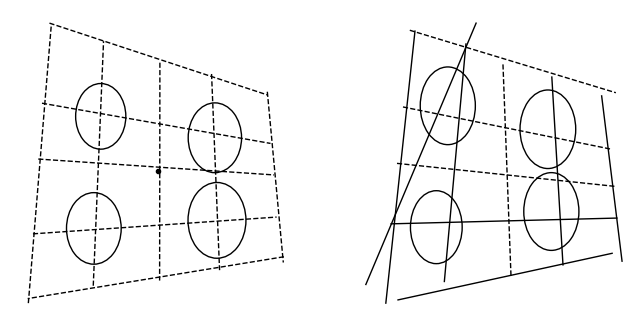

In [22]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

model.eval()
graph_idx = 2
t = 2

# Noise graph
curr_nodes, curr_edges, true_noise = model.noise_scheduler(nodes[graph_idx].to(6).unsqueeze(0), edges[graph_idx].to(6).unsqueeze(0), t)
# Predict true graph
pred_nodes, pred_edges = model(curr_nodes, curr_edges, torch.Tensor([t]).int())
# Normalize output into probabilities
pred_nodes[:,:,0] = F.sigmoid(input = pred_nodes[:,:,0])
pred_nodes[:,:,1:6] = F.softmax(input = pred_nodes[:,:,1:6], dim = 2)
pred_edges[:,:,:,0:4] = F.softmax(input = pred_edges[:,:,:,0:4], dim = 3)
pred_edges[:,:,:,4:8] = F.softmax(input = pred_edges[:,:,:,4:8], dim = 3)
pred_edges[:,:,:,8:] = F.softmax(input = pred_edges[:,:,:,8:], dim = 3)
# Run one denoising step
curr_nodes, curr_edges = model.reverse_step(curr_nodes, curr_edges, nodes[graph_idx].unsqueeze(0), edges[graph_idx].unsqueeze(0), t)
cur1_nodes, cur1_edges = model.reverse_step(curr_nodes, curr_edges, pred_nodes, pred_edges, t)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(8, 4))
SketchDataset.render_graph(curr_nodes.cpu().squeeze(0), curr_edges.cpu().squeeze(0), axes[0])
SketchDataset.render_graph(pred_nodes.cpu().squeeze(0), pred_edges.cpu().squeeze(0), axes[1])